In [111]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns

%matplotlib inline

In [124]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')

In [125]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1747 entries, 2014-01-07 to 2018-10-19
Data columns (total 7 columns):
Open                 1747 non-null float64
High                 1747 non-null float64
Low                  1747 non-null float64
Close                1747 non-null float64
Volume (BTC)         1747 non-null float64
Volume (Currency)    1747 non-null float64
Weighted Price       1747 non-null float64
dtypes: float64(7)
memory usage: 109.2 KB


In [51]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-10-15,6181.9,6820.0,6151.0,6438.5,11354.618533,7.323588e+07,6449.875590
2018-10-16,6441.3,6490.0,6391.5,6460.4,3309.324892,2.131805e+07,6441.811929
2018-10-17,6460.3,6469.8,6411.9,6442.5,1684.002001,1.084233e+07,6438.428780
2018-10-18,6442.3,6487.9,6344.6,6395.4,1779.341362,1.141324e+07,6414.303261
2018-10-19,6395.2,6406.8,6352.5,6382.1,1124.240054,7.173664e+06,6380.900682


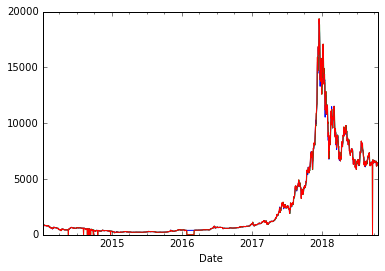

In [58]:
data['Weighted Price'].plot(label = 'Weighted')
data['Open'].plot(label = 'Open')
data['Close'].plot(label = 'Close')

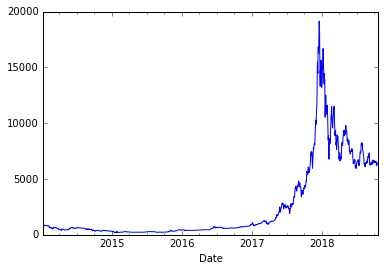

In [59]:
data['Weighted Price'].plot(label = 'Weighted')

In [53]:
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)

In [60]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [61]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [62]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

1222 525


In [134]:
train

array([[3.3914901e-02, 5.4245576e-04, 6.7377921e-05, 3.3773407e-02],
       [3.3773407e-02, 6.6608272e-04, 8.2470193e-05, 3.3372939e-02],
       [3.3372939e-02, 2.8328181e-04, 3.4757220e-05, 3.4078784e-02],
       ...,
       [8.1767961e-02, 1.8343398e-01, 4.7308661e-02, 8.6016782e-02],
       [8.6016782e-02, 2.4490678e-01, 6.6070072e-02, 8.1427544e-02],
       [8.1427544e-02, 2.4294479e-01, 6.2425766e-02, 7.8931399e-02]],
      dtype=float32)

In [132]:
train.shape
len(train)
train[1:2,0]

array([0.03377341], dtype=float32)

In [63]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [64]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1221
524


In [65]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [66]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

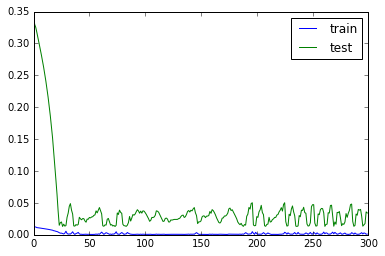

In [67]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

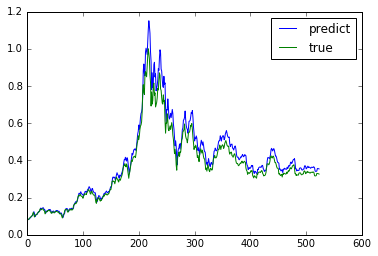

In [68]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [69]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [70]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 930.802


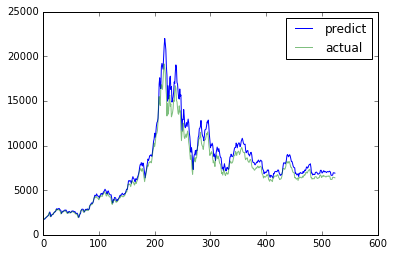

In [71]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [72]:
predictDates = data.tail(len(testX)).index

In [74]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

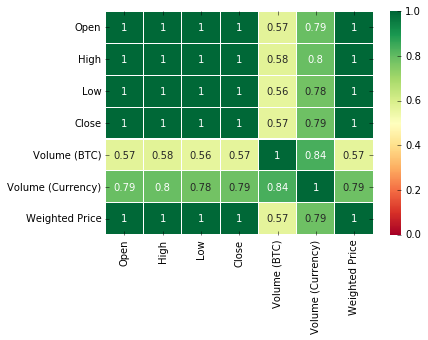

In [88]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

In [89]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [90]:
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')

In [92]:
values

array([[8.4183551e+02, 1.5622378e+01, 1.3151473e+04],
       [8.3915625e+02, 1.9182756e+01, 1.6097329e+04],
       [8.3157294e+02, 8.1583347e+00, 6.7842500e+03],
       ...,
       [6.4384287e+03, 1.6840020e+03, 1.0842327e+07],
       [6.4143032e+03, 1.7793413e+03, 1.1413235e+07],
       [6.3809009e+03, 1.1242401e+03, 7.1736640e+06]], dtype=float32)

In [93]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [94]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.033915,0.000542,0.000067,0.033773,0.000666,0.000082
2,0.033773,0.000666,0.000082,0.033373,0.000283,0.000035
3,0.033373,0.000283,0.000035,0.034079,0.000279,0.000035
4,0.034079,0.000279,0.000035,0.036494,0.000651,0.000086
5,0.036494,0.000651,0.000086,0.034898,0.000883,0.000112


In [95]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.033915   0.000542   0.000067  0.033773
2   0.033773   0.000666   0.000082  0.033373
3   0.033373   0.000283   0.000035  0.034079
4   0.034079   0.000279   0.000035  0.036494
5   0.036494   0.000651   0.000086  0.034898


In [96]:
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1222, 1, 3) (1222,) (524, 1, 3) (524,)


In [97]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

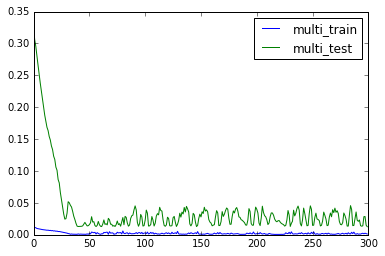

In [98]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

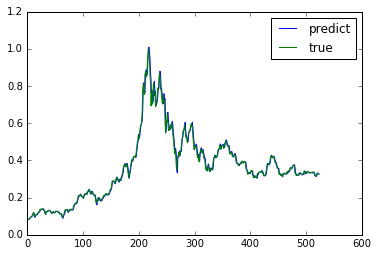

In [99]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [100]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [101]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 399.918


In [104]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')

In [113]:
import matplotlib.pyplot as pltt

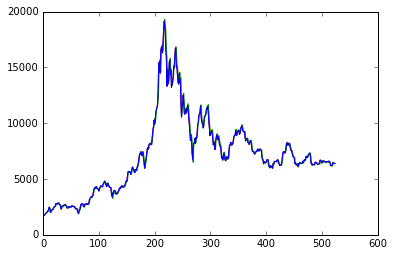

In [117]:
pltt.plot(inv_y, 'r', label = 'Actual' )
pltt.plot(inv_yhat, 'g', label = 'Multi' )
pltt.plot(inv_y, 'b', label = 'Mono' )

In [122]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.tools.set_credentials_file(username='winston107', api_key='sCoIeyDNBdAQoNqz8eai')

In [123]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~winston107/0 or inside your plot.ly account where it is named 'plot from API'
